# wandb Demo

In this lab demo we will show you an example of how to use **w**eights **and** **b**iases (wandb) to log data as you train and evaluate your models.

Tools like this are extremely useful to allow you to track how your models are performing as you experiment with different training configurations.

Before continuing, you'll need to create a free wandb account. You can do that through the website here: https://wandb.ai/


In this demo specifically, our target will be to train models to classify images from the CIFAR-10 dataset.

This dataset consists of 60,000 32x32 RGB images containing one of 10 object classes (6,000 images per-class).

You can read more about the CIFAR-10 dataset here: http://www.cs.toronto.edu/~kriz/cifar.html or here: https://www.kaggle.com/c/cifar-10

To compare loss and accuracy curves, we will train 3x different model architectures. These will be:

1. A simple custom CNN
2. [A ResNet-18 model](https://arxiv.org/abs/1512.03385)
3. A ResNet-18 model that has been pre-trained on the [ImageNet dataset](https://www.image-net.org/challenges/LSVRC/2012/).

We will leverage torchvision to allow us to load in the ResNet model definition, and importantly to download the set of weights that have already been trained on ImageNet. You can find more about how to use torchvision to use a ResNet model here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

At the bottom of the linked documentation, you'll see that the set of pre-trained weights have been trained expecting data to be transformed in the following ways:
> *The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR*

> *followed by a central crop of crop_size=[224].*

> *Finally the values are first rescaled to [0.0, 1.0] and then*

> *normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].*

For consistency, we will apply this set of transforms to the data regardless of the model we use.

For simplicity, we will just resize our images to 224x224, instead of resizing and centre cropping.

First, let's install the required dependencies, make some imports, and define some constants!

In [ ]:
# Extra dependencies
!pip install wandb==0.14.0
!pip install torchmetrics==0.11.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=94cbb04bc0cb2fb06e651d4ab46ad27e1fe4e52713d6277a6990a8daa3ecf623
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 9.8 MB/s eta 0:00:00


In [ ]:
# Imports
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchmetrics
import torchvision
import tqdm.notebook as tq
import wandb
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, mobilenet_v3_small
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [ ]:
# Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [ ]:
# When printing numbers in torch tensors, don't use scientific notation
torch.set_printoptions(sci_mode=False)

In [ ]:
# Seed function for reproducability
def seed_all(seed):
    """Seeds all RNGs with a specific seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Datasets/Dataloaders

To make things easier for us, torchvision has built-in code that can automatically download and create dataset objects for us from popular public datasets. You can read more about it here: https://pytorch.org/vision/stable/datasets.html

We will use this to automatically download and create datasets for the CIFAR-10 data.

When creating the CIFAR-10 dataset, we can also specify whether we want the subset of images used for training, or those used for testing.

Because we want to both train our models and validate their performance through training, we will create 2x datasets. One that contains training examples that we will use to update the weights of our network, and one we will use as a 'validation' set, so that we can monitor performance during training. 

**IMPORTANT:** We are using these examples as a 'validation' set. This is different to how we would normally use a 'test' set.

For each of these datasets, we also specify the set of transforms that we want to be applied to the images. These transforms are used so that the data is in the form expected by our pre-trained model. The reason we enlarge the images from 32 x 32 to 224 x 224 is that the pretrained image net models take input size of 224 x 224

In [ ]:
transforms = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
# Note the train=True flag is used for the training set
# The use of transforms resizes and normalizes the data.
cifar10_dataset_train = CIFAR10('.', train=True, download=True, transform=transforms)
# The train=False flag is used for the test set
cifar10_dataset_test = CIFAR10('.', train=False, download=True, transform=transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Let's briefly inspect these datasets:

In [ ]:
print(f'Found {len(cifar10_dataset_train)} examples in training set')
print(f'Found {len(cifar10_dataset_test)} examples in testing set')

Found 50000 examples in training set
Found 10000 examples in testing set


In [ ]:
# The dataset objects have a 'classes' instance variable, which stores the class names
print(f'Classes in CIFAR-10: {cifar10_dataset_train.classes}')

Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's get an example from the training dataset and display it.

Examples are returned as: *image, label*

In [ ]:
image, label = cifar10_dataset_train[0]
print(image.shape)      # (C, H, W) --> (3, 32, 32)
print(label)
print(cifar10_dataset_train.classes[label])     # The class at index 6 (i.e. class # 7) in the list above

torch.Size([3, 224, 224])
6
frog


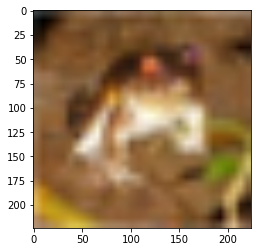

In [ ]:
# Don't be too worried about the code we use to display the image
# All it's doing is getting the image to a numpy array and unnormalizing it
image, label = cifar10_dataset_train[0]

# Torch -> Numpy
image = image.numpy()

# (C, H, W) -> (H, W, C)
image = np.transpose(image, (1, 2, 0))

# Unnormalize, clip to [0, 1]
image = np.clip(((image * IMAGENET_STD) + IMAGENET_MEAN), a_min=0, a_max=1)

plt.imshow(image)
plt.show()

Next, let's wrap these datasets in their own dataloaders so we can easily get batches of images.

As always, we will shuffle our training set, but wont shuffle our test set.

We will also set num_workers to 2 to enable multiprocessing in dataloading.

In [ ]:
train_dataloader = DataLoader(cifar10_dataset_train, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = DataLoader(cifar10_dataset_test, batch_size=16, shuffle=False, num_workers=2)

Finally, let's inspect a batch of our images!

In [ ]:
def plot_some_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    num_imgs = min(16, len(images))
    for i in range(num_imgs):
        # Select a subplot in a 4x4 grid
        ax = plt.subplot(4, 4, i + 1)
        img = images[i]
        # Transpose to expected format
        img = np.transpose(img, (1, 2, 0))
        # Unnormalize, clip to [0, 1]
        img = np.clip(((img * IMAGENET_STD) + IMAGENET_MEAN), a_min=0, a_max=1)
        # Plot the image with its class label
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

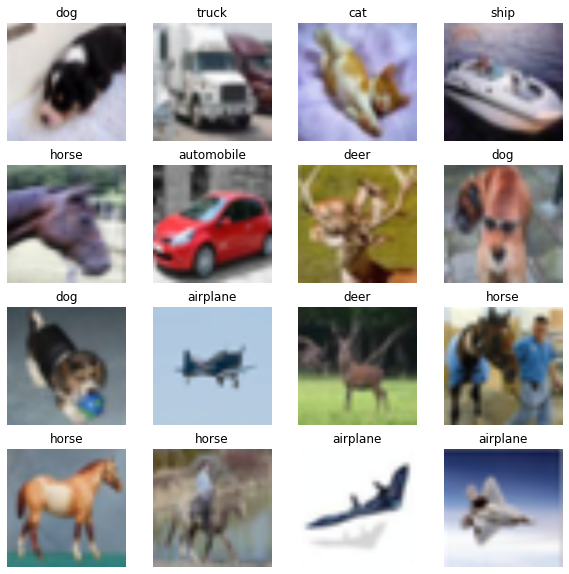

In [ ]:
# Take a batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))

# Plot!
plot_some_images(batch_images.numpy(), batch_labels, cifar10_dataset_train.classes)

## Models

Now that our dataloading is handled, let's define some models for the task of classifying these images!

To showcase how we can use wandb to make comparisons between different model configurations, we will create and train a total of 3 different models.

Each of these models is as follows:
* Simple CNN
    * A very simple CNN similar to what we saw in the Lab 3 demo. This will consist of 2 convolution layers, with BatchNorm and ReLU activations between layers. Finally, the last layer in the network will consist of a linear layer that outputs predictions across 10 classes.
* ResNet-18
    * A randomly initialized ResNet-18 model that we will get from [torchvision](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
* ResNet-18 pretrained
    * The same ResNet-18 model, however using pretrained weights (instead of randomly initialised weights)

### Simple CNN

Below we define a very simple CNN Model, and include some code to test that the model works as expected (outputs a vector of size 10 for each image in the batch).

Can you work out why the number of input features to the linear layer needs to be 125440? 

In [ ]:
class SimpleCNNModel(nn.Module):   
    def __init__(self):
        super().__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            # Defining another 2D convolution layer
            nn.Conv2d(5, 10, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(125440, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiate the model
simple_cnn_model = SimpleCNNModel()

# Sample a batch
batch = next(iter(train_dataloader))
input, label = batch

# Check no errors in producing output
output = simple_cnn_model(input)
print(output.shape)     # Expect size: [16, 10]

torch.Size([16, 10])


### ResNet-18 (Randomly initialised)

Below we instantiate a randomly initialized ResNet-18 model using the models supplied by torchvision.

We specify the number of classes such that the output of the final linear layer will be suitable for our task.

In [ ]:
# Instantiate the model
resnet_18_model = resnet18(num_classes=10, weights=None)

# Sample a batch
batch = next(iter(train_dataloader))
input, label = batch

# Check no errors in producing output
output = resnet_18_model(input)
print(output.shape)     # Expect size: [16, 10]

torch.Size([16, 10])


### ResNet-18 (Pretrained on ImageNet)
Below we instantiate a ResNet-18 model using the models supplied by torchvision.

For this model, we specify that it should use a set of weights that have been pretrained on the ImageNet dataset. You can read more about it [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights).

Because we are using a pre-trained model, we need to replace the final linear layer with a new linear layer that produces the correct number of outputs (10 in our example for 10 classes). This layer will be randomly initialised.

In [ ]:
# Instantiate the model
resnet_18_model_pretrained = resnet18(weights='IMAGENET1K_V1')

# Replace the last linear layer with one that produces outputs for 10 classes.
resnet_18_model_pretrained.fc = nn.Linear(in_features=resnet_18_model_pretrained.fc.in_features, out_features=10, bias=True)

# Sample a batch
batch = next(iter(train_dataloader))
input, label = batch

# Check no errors in producing output
output = resnet_18_model_pretrained(input)
print(output.shape)     # Expect size: [16, 10]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([16, 10])


## Training/Evaluating

Now we have our dataloader and models covered, let's create our training loop and then begin to train/test our models!

First, let's choose the device to use (GPU if available, otherwise CPU).

In [ ]:
# By default we'll assume that GPU acceleration isn't available
device = torch.device('cpu')

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)

print('Training on', device)

Training on cuda:0


Now we'll define some helper functions to train our model for an epoch and to evaluate our model over the 'test' set.

Per-epoch, these functions will return the average epoch loss and the accuracy across data in the epoch.

In [ ]:
def train_epoch(model, optimizer, loss_func, train_loader, device):
    """
    Perform one epoch of training on the provided model.
    """
    # Initialize metrics
    epoch_loss = torchmetrics.MeanMetric().to(device)
    acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

    # Put model onto GPU
    model.to(device)

    # Training loop
    model.train() # ensure the model is in train mode before training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference, calculate gradients and update weights
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        epoch_loss(loss)
        acc_metric(outputs, labels)

    return epoch_loss.compute(), acc_metric.compute()


def test_epoch(model, loss_func, test_loader, device):
    """
    Evaluate the model on the entire test set.
    """
    # Initialize metrics
    epoch_loss = torchmetrics.MeanMetric().to(device)
    acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

    model.eval() # ensure the model is in eval mode before testing loop
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference without gradients.
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

        # Accumulate metrics
        epoch_loss(loss)
        acc_metric(outputs, labels)

    return epoch_loss.compute(), acc_metric.compute()

Finally, we'll create a helper function that handles training and testing our models.

You'll note in here we are using weights and biases to track the loss and accuracy of our models.

Here we evaluate the test set every epoch. Normally we would only do this for a validation set, however in our example, we are treating the 'test' set as a 'validation' set.

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs, loss_func, optimizer, device, project_name, experiment_name):
    """
    Completely train and evaluate the model over all epochs.

    Uses only a train and test split, so test data is used for validation.
    """
    # Initialise the weights and biases run
    run = wandb.init(project=project_name, name=experiment_name)

    # Train by iterating over epochs
    for epoch in tq.tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
        train_epoch_loss, train_epoch_accuracy = \
            train_epoch(model, optimizer, loss_func, train_loader, device)
        test_epoch_loss, test_epoch_accuracy = \
            test_epoch(model, loss_func, test_loader, device)

        print(f'Epoch: {epoch}. Train loss: {train_epoch_loss:.3f},  accuracy: {train_epoch_accuracy:.3f}. Test loss: {test_epoch_loss:.3f} accuracy: {test_epoch_accuracy:.3f}')

        # Log to weights and biases
        wandb.log({
            'train_loss': train_epoch_loss,
            'train_accuracy': train_epoch_accuracy,
            'test_loss': test_epoch_loss,
            'test_accuracy': test_epoch_accuracy
        })
    
    # Finish wandb run
    run.finish()

Now we've got everything set up, let's train each of our three models.

The first time you train a model you will be prompted to login to weights and biases to get your API key that will allow the colab notebook to communicate with weights and biases.

Given time constraints, we will only train each model for 5x epochs. If you're interested, you could later try training these for longer, or playing around with learning rates/optimizers/etc.

### Training the Simple CNN

On a GPU, this should take around 2 minutes per-epoch (~10 minutes in total for 5x epochs).

Once training has started, you should see a link to weights and biases that you can follow to see the progress of your model training!

In [ ]:
project_name = 'CSE5DL wandb Demo'
experiment_name = 'Simple CNN'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=0.0001)
num_epochs = 5

seed_all(42)
train_model(simple_cnn_model, train_dataloader, test_dataloader, num_epochs, criterion, optimizer, device, project_name, experiment_name)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0. Train loss: 2.393,  accuracy: 0.334. Test loss: 2.106 accuracy: 0.403
Epoch: 1. Train loss: 1.668,  accuracy: 0.456. Test loss: 1.566 accuracy: 0.474
Epoch: 2. Train loss: 1.357,  accuracy: 0.532. Test loss: 1.442 accuracy: 0.506
Epoch: 3. Train loss: 1.192,  accuracy: 0.586. Test loss: 1.438 accuracy: 0.506
Epoch: 4. Train loss: 1.067,  accuracy: 0.632. Test loss: 1.434 accuracy: 0.521


test_accuracy,▁▅▇▇█
test_loss,█▂▁▁▁
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
test_accuracy,0.5207
test_loss,1.43411
train_accuracy,0.6317
train_loss,1.06657


Now our model is trained, let's see how well it performs on a sample batch of data!

The predicted logits
tensor([[ -4.0253,  -7.8219,  -3.9382,   1.2275,  -7.2160,  -1.7835,  -0.9568,
          -6.8850,  -1.9088,  -4.3423],
        [  2.6200,   3.8126,  -3.9165,  -5.1627,  -8.3887,  -9.0835,  -5.7053,
          -6.5965,   5.4686,   0.4003],
        [  1.2594,  -1.3363,  -3.3961,  -2.3113,  -3.2184,  -4.6386,  -3.9085,
          -4.4620,   1.4168,  -1.3456],
        [ -1.0153,   0.6257,  -0.4473,  -4.3650,  -6.1849,  -8.4710,  -2.5579,
          -5.4140,   1.4677,   1.0199],
        [ -9.8227,  -6.1053,  -4.3019,  -1.2487,   3.0291,  -2.2042,   0.6889,
          -5.3790,  -7.7160,  -7.0216],
        [ -5.8838,  -3.9785,  -2.8904,   0.1680,  -2.3490,   0.4683,   1.6638,
          -1.6981,  -6.4736,  -3.8548],
        [ -4.2795,  -0.8192,  -6.6860,  -2.4094, -10.2912,   0.1270,  -1.2047,
          -5.1797,  -9.7136,  -3.5243],
        [ -2.8247,  -6.6705,  -0.7382,   0.0489,  -1.2005,  -0.8035,  -0.3628,
          -0.7666,  -4.0392,  -5.4526],
        [ -3.2204,  -5.0058

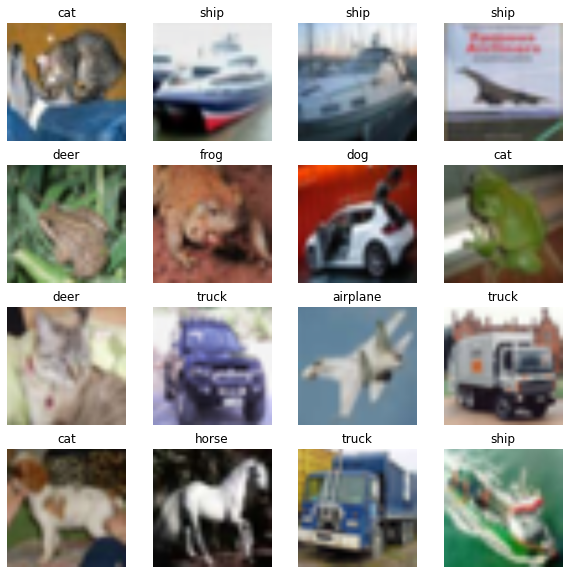

Did we get the prediction correct?
tensor([ True,  True,  True, False, False,  True, False, False, False, False,
         True,  True, False,  True,  True,  True])
Accuracy: 56.250%


In [ ]:
# Sample a batch from the 'testing' dataset
batch = next(iter(test_dataloader))
inputs, labels = batch

# Put data onto correct device (e.g. GPU)
inputs, labels = inputs.to(device), labels.to(device)

# Ensure model on correct device and in 'eval' mode, then perform forward pass
simple_cnn_model.to(device)
simple_cnn_model.eval()
with torch.no_grad():
    output = simple_cnn_model(inputs)

# Inspect the predictions
print('The predicted logits')
print(output)
predicted_labels = torch.argmax(output, dim=1)
print('The predicted classes')
print(predicted_labels)

# Visualise the predictions
plot_some_images(inputs.cpu().numpy(), predicted_labels, cifar10_dataset_test.classes)

# Compare predictions to ground truth
print('Did we get the prediction correct?')
print(predicted_labels.cpu() == labels.cpu())
print(f'Accuracy: {100 * torch.mean(predicted_labels.cpu() == labels.cpu(), dtype=torch.float32).item():.3f}%')

<font color="red">Was the accuracy of this batch similar to the overall test set accuracy of the model?</font>

### Training the ResNet-18 Model

On a GPU, this should take around 3-4 minutes per-epoch (~15-20 minutes in total for 5x epochs).

In [ ]:
project_name = 'CSE5DL wandb Demo'
experiment_name = 'ResNet-18'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_18_model.parameters(), lr=0.0001)
num_epochs = 5

seed_all(42)
train_model(resnet_18_model, train_dataloader, test_dataloader, num_epochs, criterion, optimizer, device, project_name, experiment_name)

wandb: Currently logged in as: zhenhe1. Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0. Train loss: 1.272,  accuracy: 0.543. Test loss: 0.938 accuracy: 0.663
Epoch: 1. Train loss: 0.792,  accuracy: 0.724. Test loss: 0.765 accuracy: 0.733
Epoch: 2. Train loss: 0.594,  accuracy: 0.798. Test loss: 0.594 accuracy: 0.796
Epoch: 3. Train loss: 0.456,  accuracy: 0.844. Test loss: 0.565 accuracy: 0.810
Epoch: 4. Train loss: 0.341,  accuracy: 0.883. Test loss: 0.581 accuracy: 0.806


test_accuracy,▁▄▇██
test_loss,█▅▂▁▁
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
test_accuracy,0.8061
test_loss,0.58138
train_accuracy,0.88286
train_loss,0.34104


Now our model is trained, let's see how well it performs on a sample batch of data!

The predicted logits
tensor([[    -3.9883,     -1.3883,     -1.7291,      6.0316,     -2.9011,
              2.8084,     -2.1268,     -3.7832,     -5.7216,     -8.4707],
        [     0.1172,      6.5955,     -4.5270,     -4.3475,     -5.7126,
             -6.5130,     -6.8427,     -4.3570,     10.7020,     -1.6127],
        [     1.8145,      2.4682,     -1.7234,     -3.3569,     -0.4021,
             -5.8865,     -4.5292,     -3.6706,      4.9986,     -2.8603],
        [     5.0018,      0.0447,     -0.3627,     -1.9796,     -3.7923,
             -5.8513,     -5.9023,     -3.4172,      2.6576,     -1.2089],
        [    -4.8170,     -0.0562,     -0.3765,     -1.5148,      1.8716,
             -3.2747,      5.5089,     -6.5522,     -1.9350,     -5.1170],
        [    -6.4256,     -4.6986,     -4.8642,      1.2023,     -1.0037,
              2.0380,      6.8495,     -3.1124,     -3.1573,     -5.1555],
        [    -3.8562,      5.6910,     -1.1086,      0.9798,     -4.6398,
           

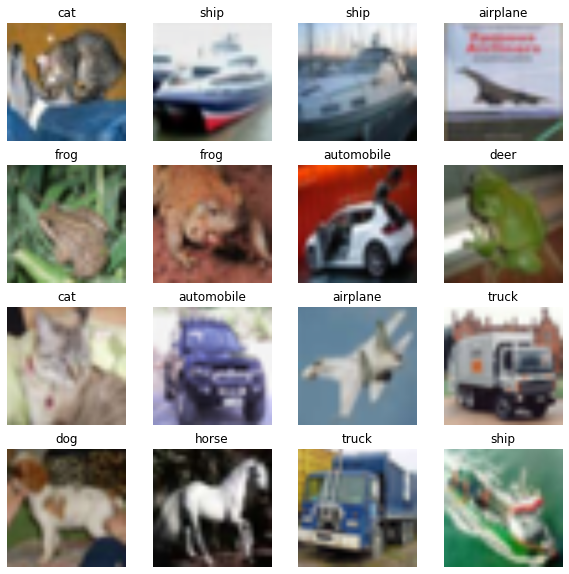

Did we get the prediction correct?
tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True])
Accuracy: 93.750%


In [ ]:
# Sample a batch from the 'testing' dataset
batch = next(iter(test_dataloader))
inputs, labels = batch

# Put data onto correct device (e.g. GPU)
inputs, labels = inputs.to(device), labels.to(device)

# Ensure model in 'eval' mode, and perform forward pass
resnet_18_model.to(device)
resnet_18_model.eval()
with torch.no_grad():
    output = resnet_18_model(inputs)

# Inspect the predictions
print('The predicted logits')
print(output)
predicted_labels = torch.argmax(output, dim=1)
print('The predicted classes')
print(predicted_labels)

# Visualise the predictions
plot_some_images(inputs.cpu().numpy(), predicted_labels, cifar10_dataset_test.classes)

# Compare predictions to ground truth
print('Did we get the prediction correct?')
print(predicted_labels.cpu() == labels.cpu())
print(f'Accuracy: {100 * torch.mean(predicted_labels.cpu() == labels.cpu(), dtype=torch.float32).item():.3f}%')

<font color="red">Was the accuracy of this batch similar to the overall test set accuracy of the model?</font>

### Training the Pre-trained ResNet-18 Model

On a GPU, this should take around 3-4 minutes per-epoch (~15-20 minutes in total for 5x epochs).

In [ ]:
project_name = 'CSE5DL wandb Demo'
experiment_name = 'ResNet-18 Pretrained'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_18_model_pretrained.parameters(), lr=0.0001)
num_epochs = 5

seed_all(42)
train_model(resnet_18_model_pretrained, train_dataloader, test_dataloader, num_epochs, criterion, optimizer, device, project_name, experiment_name)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0. Train loss: 0.379,  accuracy: 0.873. Test loss: 0.212 accuracy: 0.928
Epoch: 1. Train loss: 0.180,  accuracy: 0.939. Test loss: 0.200 accuracy: 0.932
Epoch: 2. Train loss: 0.116,  accuracy: 0.961. Test loss: 0.211 accuracy: 0.935
Epoch: 3. Train loss: 0.082,  accuracy: 0.972. Test loss: 0.217 accuracy: 0.935
Epoch: 4. Train loss: 0.067,  accuracy: 0.977. Test loss: 0.224 accuracy: 0.931


test_accuracy,▁▅██▄
test_loss,▅▁▄▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
test_accuracy,0.9306
test_loss,0.22408
train_accuracy,0.97732
train_loss,0.06743


Now our model is trained, let's see how well it performs on a sample batch of data!

The predicted logits
tensor([[ -2.4981,  -6.6418,   1.7145,   9.9199,  -9.0477,  -0.5877,  -5.8146,
          -7.5463,  -3.9838,  -7.1510],
        [  1.1421,  -3.3240,  -4.5344,  -6.8695, -11.5083,  -6.8919, -11.6878,
          -7.7040,  17.3169,  -5.9746],
        [ -1.0353,   0.8197,  -3.6602,  -8.7211,  -7.9848,  -4.3789, -10.5763,
          -2.0409,  12.8458,  -4.1968],
        [  5.9023,  -5.3506,   1.9109,  -1.1288,  -8.7638,  -6.5529,  -4.6068,
          -4.6354,  -0.4707,  -2.2304],
        [ -8.4881,  -1.4673,  -0.1015,  -6.1829,  -2.9716,  -6.2512,  12.3108,
         -10.8133,  -8.6857,  -7.5945],
        [ -8.0819,  -5.9459,  -6.8727,  -1.2822,  -6.7973,  -3.2461,  12.6245,
          -3.7581,  -8.7025,  -5.0642],
        [ -3.1294,   8.1627,  -5.5781,  -6.9501,  -8.9654,  -2.1197,  -7.7243,
          -3.4425,  -4.9139,   2.1589],
        [ -4.5849,  -7.0251,  -2.1131,  -0.3071,  -4.9560,  -1.2409,   7.4708,
          -3.6569, -10.9507,  -2.3439],
        [ -1.6623, -10.3800

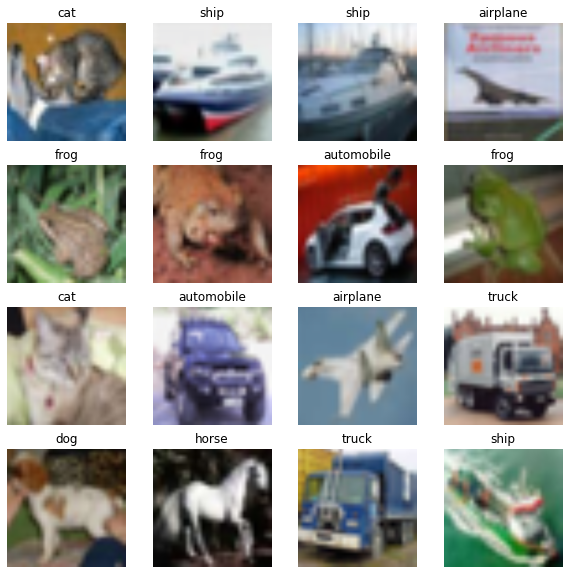

Did we get the prediction correct?
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
Accuracy: 100.000%


In [ ]:
# Sample a batch from the 'testing' dataset
batch = next(iter(test_dataloader))
inputs, labels = batch

# Put data onto correct device (e.g. GPU)
inputs, labels = inputs.to(device), labels.to(device)

# Ensure model in 'eval' mode, and perform forward pass
resnet_18_model_pretrained.to(device)
resnet_18_model_pretrained.eval()
with torch.no_grad():
    output = resnet_18_model_pretrained(inputs)

# Inspect the predictions
print('The predicted logits')
print(output)
predicted_labels = torch.argmax(output, dim=1)
print('The predicted classes')
print(predicted_labels)

# Visualise the predictions
plot_some_images(inputs.cpu().numpy(), predicted_labels, cifar10_dataset_test.classes)

# Compare predictions to ground truth
print('Did we get the prediction correct?')
print(predicted_labels.cpu() == labels.cpu())
print(f'Accuracy: {100 * torch.mean(predicted_labels.cpu() == labels.cpu(), dtype=torch.float32).item():.3f}%')

<font color="red">Was the accuracy of this batch similar to the overall test set accuracy of the model?</font>